In [1]:
import os
from collections import defaultdict

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]

# Loading data

In [2]:
data = {}
for file in os.listdir("./features"):
    df= pd.read_csv(os.path.join("features", file), index_col = 0)
    df["activity"] = file.split("_")[0]
    data[file.split(".")[0]] = df
    

At the moment only bike data has more than one dataset so the test data for the other activities is created by taking the last 30% of the 5-second epochs from the data. Additional data with different mobile phone placement, different participants etc. would be interesting and would probably make the classification a lot more difficult.

In [3]:
train, test = data["bike_2"], data["bike_1"]
for key in data:
    if "bike" not in key:
        train = train.append(data[key][:int(len(data[key])*.7)], ignore_index = True)
        test = test.append(data[key][int(len(data[key])*.7):], ignore_index = True)
train_y, train_x = train["activity"], train.drop(columns = "activity")
test_y, test_x = test["activity"], test.drop(columns = "activity")

# Testing different classifiers

Test accuracy and confusion matrices printed for each classifier

In [4]:
model = RandomForestClassifier()
model.fit(train_x, train_y)
pred = model.predict(test_x)
print(model.score(test_x, test_y))
confusion_matrix(pred, test_y, labels = ["bike", "walk", "car", "idle"])

0.9731543624161074


array([[116,   5,   1,   2],
       [  2,  98,   2,   0],
       [  0,   0,  69,   0],
       [  0,   0,   0, 152]], dtype=int64)

In [5]:
model = GaussianNB()
model.fit(train_x, train_y)
pred = model.predict(test_x)
print(model.score(test_x, test_y))
confusion_matrix(pred, test_y, labels = ["bike", "walk", "car", "idle"])

0.9395973154362416


array([[115,  11,   2,   3],
       [  3,  92,   1,   0],
       [  0,   0,  69,   7],
       [  0,   0,   0, 144]], dtype=int64)

In [6]:
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1000))
model.fit(train_x, train_y)
pred = model.predict(test_x)
print(model.score(test_x, test_y))
confusion_matrix(pred, test_y, labels = ["bike", "walk", "car", "idle"])

0.9798657718120806


array([[116,   3,   0,   1],
       [  2, 100,   1,   0],
       [  0,   0,  71,   2],
       [  0,   0,   0, 151]], dtype=int64)

In [7]:
model = make_pipeline(StandardScaler(), SVC(kernel = "linear"))
model.fit(train_x, train_y)
pred = model.predict(test_x)
print(model.score(test_x, test_y))
confusion_matrix(pred, test_y, labels = ["bike", "walk", "car", "idle"])

0.9753914988814317


array([[116,   3,   0,   2],
       [  2, 100,   1,   0],
       [  0,   0,  71,   3],
       [  0,   0,   0, 149]], dtype=int64)

In [8]:
model = make_pipeline(StandardScaler(), KNeighborsClassifier())
model.fit(train_x, train_y)
pred = model.predict(test_x)
print(model.score(test_x, test_y))
confusion_matrix(pred, test_y, labels = ["bike", "walk", "car", "idle"])

0.9642058165548099


array([[117,   7,   2,   3],
       [  1,  96,   1,   0],
       [  0,   0,  68,   1],
       [  0,   0,   1, 150]], dtype=int64)

The classification task seems to be very easy in the current dataset and only the Naive Bayes classifier has any trouble with the classification. As such hyperparameter tuning and further model selection seems unnecessary at the moment. With more data probably would be interesting to include.

## Convolutional neural network approach

For the neural network experiment the feature engineering isn't done by hand. Instead the inputs are 5-second epochs of the  raw rotated accelerometer-signals. The neural network architecture consists of 1 2d-convolution layer for handling the signal at first as a 3 (axes) * 100 (5 seconds * 20 samples/second) matrix, 1 1d-convolution-layer and 4 fully connected layers.

In [9]:
import NN 
import pickle
with open("nn_train.pickle", "rb") as f:
    nn_train = pickle.load(f)
with open("nn_test.pickle", "rb") as f:
    nn_test = pickle.load(f)
    

In [48]:
model = NN.train(nn_train)

epoch: 1/10


G:\Users\Business Time\Tiedostot\HAR-experiment\my_sensor_data\sheish\NN.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(labels))


epoch: 2/10
epoch: 3/10
epoch: 4/10
epoch: 5/10
epoch: 6/10
epoch: 7/10
epoch: 8/10
epoch: 9/10
epoch: 10/10
Finished Training


In [50]:
y_pred, label = NN.evaluate(model, nn_test)
print(accuracy_score(label, y_pred))
confusion_matrix(label, y_pred)

0.9024943310657596


array([[ 70,  31,   0,   0],
       [  5, 113,   0,   0],
       [  0,   3, 149,   0],
       [  0,   2,   2,  66]], dtype=int64)

Seems to fair a bit worse than traditional approaches.
TODO: different architectures...

# Feature importance assessment

Clustering some of the correlating features together. The aim is to reduce multicollinearity in the features. This makes feature importance calculation more accurate and interpretable. Modified from tutorials found in sklearn documentation.

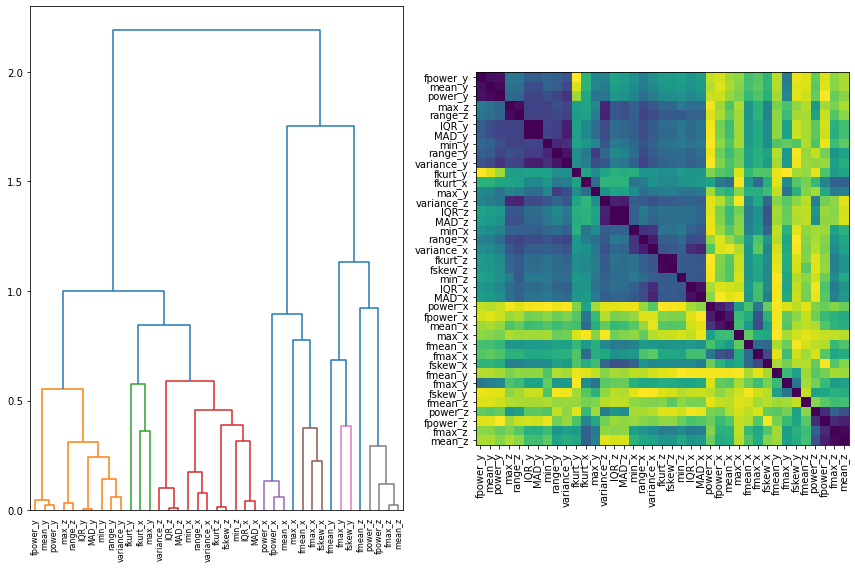

In [15]:
num_clusts = 12
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(train_x).correlation

corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)
corr = 1 - abs(corr)
R, _ = corr.shape 
condensed_dist=([c for row in range(R) for c in corr[row,row+1:]])
    
dist_linkage = hierarchy.ward(condensed_dist)
clustering = hierarchy.fcluster(dist_linkage, num_clusts, criterion = "maxclust")
i = 0
while len(np.unique(hierarchy.fcluster(dist_linkage, dist_linkage[i][2]))) >= len(np.unique(clustering)):
    i += 1
    
dendro = hierarchy.dendrogram(
    dist_linkage, color_threshold = dist_linkage[i-1][2], labels=test_x.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

Select the most important feature from each cluster using the importance value of the features in a random forest trained on all the features. The random forest feature importance takes into account the amount of times each feature are used in a split.

In [38]:
model = RandomForestClassifier()
model.fit(train_x, train_y)
clusters = defaultdict(list)
for ind, cluster_id in enumerate(clustering):
    clusters[cluster_id].append(ind)
    
sel = []    
for cluster_id in clusters:
    cluster = clusters[cluster_id]
    sel_ind = cluster[model.feature_importances_[cluster].argmax()]
    sel.append(test_x.columns[sel_ind])    

Train a model using the pruned featureset.

In [40]:
model_pruned = RandomForestClassifier()
model_pruned.fit(train_x[sel], train_y)
pred = model_pruned.predict(test_x[sel])
print(model_pruned.score(test_x[sel], test_y))
confusion_matrix(pred, test_y, labels = ["bike", "walk", "car", "idle"])

0.9753914988814317


array([[118,   7,   0,   3],
       [  0,  96,   1,   0],
       [  0,   0,  71,   0],
       [  0,   0,   0, 151]], dtype=int64)

Does not seem to affect the results much.

Next we calculate the permutation importances for the random forest model trained using the pruned featureset. The permutation importance tells how much randomizing a given feature affects the final accuracy of the model.

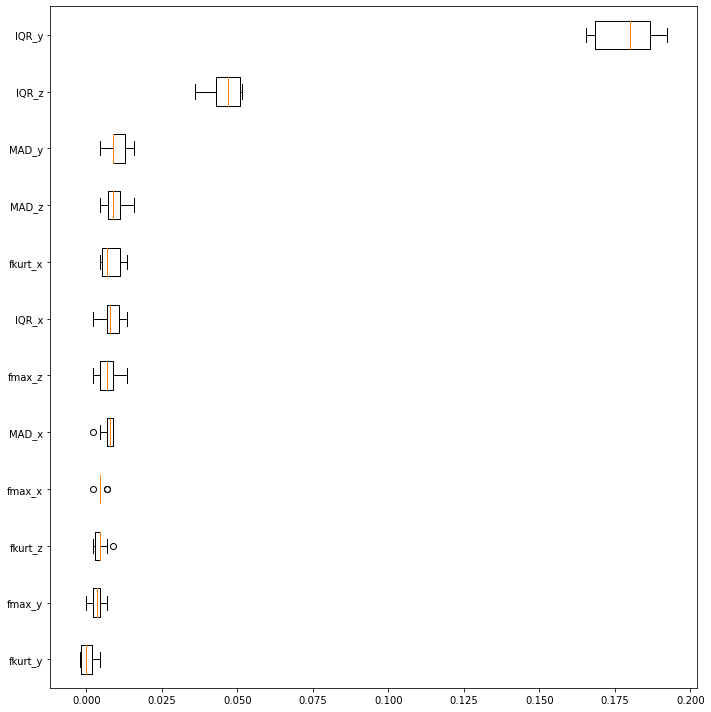

In [42]:
perm_imp = permutation_importance(model_pruned, test_x[sel], test_y, n_repeats=10)
idx = perm_imp.importances_mean.argsort()
plt.boxplot(
    perm_imp.importances[idx].T,
    vert = False,
    labels = np.array(test_x.columns)[idx],
)
plt.tight_layout()

The most important features seem to be the interquartile ranges on the z- and y-axes.